<a href="https://colab.research.google.com/github/diazveraserrano-boop/Actividad-2-Procesamiento-de-Imagen/blob/main/Actividad_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
download_path = kagglehub.dataset_download("nikitamanaenkov/fundus-image-dataset-for-vessel-segmentation")

print("Path to dataset files:", download_path)

Using Colab cache for faster access to the 'fundus-image-dataset-for-vessel-segmentation' dataset.
Path to dataset files: /kaggle/input/fundus-image-dataset-for-vessel-segmentation


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization,Conv2DTranspose,Activation,concatenate,Input
from tensorflow.keras import Sequential,Model
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import matplotlib.pyplot as plt

In [3]:
def conv_block(input, filters):
    x = Conv2D(filters, 3, padding="same", kernel_initializer=tf.keras.initializers.HeNormal())(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, 3, padding="same", kernel_initializer=tf.keras.initializers.HeNormal())(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def encoder_block(input, filters):
    x = conv_block(input, filters)
    p = MaxPooling2D((2,2))(x)
    return x, p

def decoder_block(input, skip, filters):
    x = Conv2DTranspose(filters, 2, strides=2, padding="same",
                        kernel_initializer=tf.keras.initializers.HeNormal())(input)
    x = concatenate([x, skip])
    x = conv_block(x, filters)
    return x

In [4]:
def build_model():
    input = Input(shape=(256,256,3))

    x1,p1 = encoder_block(input,64)
    x2,p2 = encoder_block(p1,128)
    x3,p3 = encoder_block(p2,256)
    x4,p4 = encoder_block(p3,512)

    a1 = conv_block(p4,1024)

    d1 = decoder_block(a1,x4,512)
    d2 = decoder_block(d1,x3,256)
    d3 = decoder_block(d2,x2,128)
    d4 = decoder_block(d3,x1,64)

    output = Conv2D(1,(1,1),padding="same",activation="sigmoid")(d4)
    model = Model(input,output)
    return model

In [5]:
def load_data(path,img_size):
    images = []
    masks = []
    num_images = 100

    for img_files,mask_files in zip(os.listdir(path+"/Original")[:num_images],os.listdir(path+"/Ground truth")[:num_images]):
        img_path = os.path.join(path+"/Original",img_files)
        mask_path = os.path.join(path+"/Ground truth",mask_files)

        img = load_img(img_path,target_size=img_size)
        mask = load_img(mask_path,target_size=img_size,color_mode="grayscale")

        img = img_to_array(img)/255.0
        mask = img_to_array(mask)/255.0

        images.append(img)
        masks.append(mask)
    return np.array(images),np.array(masks)

In [6]:
def augment_image(image, mask):

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, mask

In [7]:
import tensorflow as tf  # Operaciones tensoriales

def dice_loss(y_true, y_pred):  # Calcula Dice Loss desde cero
    y_true_f = tf.reshape(y_true, [-1])  # Aplana la GT
    y_pred_f = tf.reshape(y_pred, [-1])  # Aplana la predicción
    inter = tf.reduce_sum(y_true_f * y_pred_f)  # Intersección
    denom = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)  # Denominador
    dice = (2 * inter + 1e-7) / (denom + 1e-7)  # Coeficiente Dice
    return 1 - dice  # Pérdida Dice = 1 - Dice

bce = tf.keras.losses.BinaryCrossentropy()  # BCE estándar

def bce_dice_loss(y_true, y_pred):  # Combina BCE y Dice
    return 0.5 * bce(y_true, y_pred) + 0.5 * dice_loss(y_true, y_pred)  # Media ponderada

In [8]:
x_train,y_train = load_data(f"{download_path}/train",img_size=(256,256))
x_test,y_test = load_data(f"{download_path}/test",img_size=(256,256))
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((100, 256, 256, 3),
 (100, 256, 256, 1),
 (100, 256, 256, 3),
 (100, 256, 256, 1))

In [9]:
def tf_dataset(x,y,batch_size=2):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size=8)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = tf_dataset(x_train,y_train,batch_size=2)
test_dataset = tf_dataset(x_test,y_test,batch_size=2)

In [10]:
from tensorflow.keras.optimizers import Adam, RMSprop, SGD  # Optimizador Adam (baseline)


model = build_model()
model.compile(optimizer="RMSprop",loss=dice_loss,metrics=["accuracy"])

In [13]:
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_dice_coef',
                             save_best_only=True, mode='max', verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min', verbose=1, restore_best_weights=True)

In [14]:
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=test_dataset,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.6221 - loss: 0.8122 - val_accuracy: 0.5894 - val_loss: 0.8479
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step - accuracy: 0.6801 - loss: 0.8095 - val_accuracy: 0.7386 - val_loss: 0.8811
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.7426 - loss: 0.8008 - val_accuracy: 0.8185 - val_loss: 0.8085
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step - accuracy: 0.8149 - loss: 0.7962 - val_accuracy: 0.6441 - val_loss: 0.8143
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.7051 - loss: 0.8079 - val_accuracy: 0.7188 - val_loss: 0.8137
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.8420 - loss: 0.7448 - val_accuracy: 0.8405 - val_loss: 0.7807
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step - accuracy: 0.8327 - loss: 0.7656 - val_accuracy: 0.8437 - val_loss: 0.7818
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 0.8475 - loss: 0.7709 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


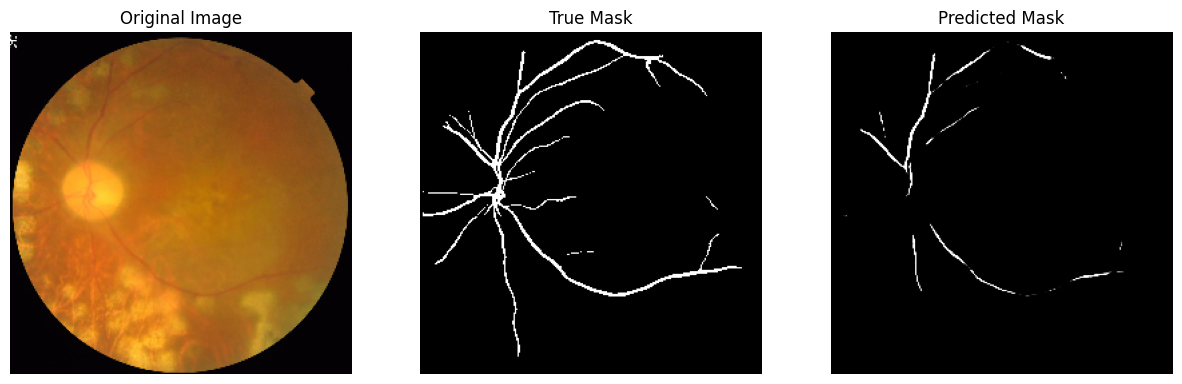

In [15]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('best_model.keras', custom_objects={'dice_loss': dice_loss})

# Select a random image from the test set
import random
n = random.randint(0, len(x_test) - 1)
image = x_test[n]
mask = y_test[n]

# Make a prediction
prediction = best_model.predict(np.expand_dims(image, axis=0))[0]

# Visualize the results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask[:, :, 0], cmap='gray')
plt.title('True Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(prediction[:, :, 0], cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()

In [16]:
from sklearn.metrics import f1_score
import numpy as np

def iou_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    iou = (intersection + 1e-15) / (union + 1e-15)
    return iou

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred) * 2
    sum_of_areas = np.sum(y_true) + np.sum(y_pred)
    dice = (intersection + 1e-15) / (sum_of_areas + 1e-15)
    return dice

# Convert prediction and mask to binary (0 or 1)
# A threshold of 0.5 is commonly used for binary segmentation
binary_prediction = (prediction > 0.5).astype(np.float32)
binary_mask = mask.astype(np.float32)

# Flatten the arrays for F1-score calculation (expects 1D arrays)
flat_binary_prediction = binary_prediction.flatten()
flat_binary_mask = binary_mask.flatten()

# Calculate F1-score
f1 = f1_score(flat_binary_mask, flat_binary_prediction)

# Calculate IoU
iou = iou_score(binary_mask, binary_prediction)

# Calculate Dice Coefficient
dice = dice_coefficient(binary_mask, binary_prediction)

print(f"F1-score: {f1:.4f}")
print(f"IoU (Intersection over Union): {iou:.4f}")
print(f"Dice Coefficient: {dice:.4f}")

F1-score: 0.4102
IoU (Intersection over Union): 0.2580
Dice Coefficient: 0.4102


In [17]:
accuracy = history.history['accuracy']
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

print("Accuracy:", accuracy)
print("Loss:", loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Loss:", val_loss)

Accuracy: [0.6318353414535522, 0.6920358538627625, 0.7738705277442932, 0.7716208100318909, 0.7290913462638855, 0.8324177265167236, 0.8490536212921143, 0.8381887674331665, 0.8480929732322693, 0.8687744140625, 0.8854016065597534, 0.8751142621040344, 0.882777988910675, 0.8517756462097168, 0.8923513889312744, 0.877076268196106, 0.862898588180542, 0.8617852926254272, 0.8809869289398193, 0.8887084722518921, 0.8816627264022827, 0.860350489616394, 0.901805579662323, 0.8813984394073486, 0.8809658885002136, 0.8739451766014099, 0.9001858234405518, 0.8815608024597168, 0.8793302774429321, 0.8842973113059998, 0.8771563768386841, 0.8884605169296265, 0.8822451829910278, 0.8816196918487549, 0.8960142731666565, 0.8965861797332764, 0.8921549916267395, 0.8885862827301025, 0.8926475644111633, 0.8889744281768799, 0.8891943097114563, 0.8822928071022034, 0.886152982711792, 0.8978326320648193, 0.8841076493263245, 0.8938827514648438, 0.8826158046722412, 0.9028630256652832, 0.8947222828865051, 0.883887767791748,

Creador de gráficas

In [18]:
import matplotlib.pyplot as plt  # Para crear las gráficas

def plot_training_curves(acc_list, loss_list, val_acc_list, val_loss_list, labels):
    """
    acc_list, loss_list, val_acc_list, val_loss_list: listas de 3 listas (una por configuración)
    labels: lista de 3 strings con los nombres de cada configuración
    """
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # Matriz 2x2 de subplots

    # --- Accuracy ---
    ax = axes[0, 0]
    for y, lab in zip(acc_list, labels):
        x = range(1, len(y) + 1)
        ax.plot(x, y, label=lab)
    ax.set_title("Accuracy vs Epochs")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.grid(True, linestyle="--", linewidth=0.5)
    ax.legend()

    # --- Loss ---
    ax = axes[0, 1]
    for y, lab in zip(loss_list, labels):
        x = range(1, len(y) + 1)
        ax.plot(x, y, label=lab)
    ax.set_title("Loss vs Epochs")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.grid(True, linestyle="--", linewidth=0.5)
    ax.legend()

    # --- Val Accuracy ---
    ax = axes[1, 0]
    for y, lab in zip(val_acc_list, labels):
        x = range(1, len(y) + 1)
        ax.plot(x, y, label=lab)
    ax.set_title("Validation Accuracy vs Epochs")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Val Accuracy")
    ax.grid(True, linestyle="--", linewidth=0.5)
    ax.legend()

    # --- Val Loss ---
    ax = axes[1, 1]
    for y, lab in zip(val_loss_list, labels):
        x = range(1, len(y) + 1)
        ax.plot(x, y, label=lab)
    ax.set_title("Validation Loss vs Epochs")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Val Loss")
    ax.grid(True, linestyle="--", linewidth=0.5)
    ax.legend()

    plt.tight_layout()  # Ajuste estilo paper
    plt.show()


In [19]:
acc_1 =  [
    # 1–10
    0.5394, 0.5819, 0.6511, 0.6677, 0.7397,
    0.8130, 0.8514, 0.8234, 0.8532, 0.8629,
    # 11–20
    0.8672, 0.8833, 0.8638, 0.8755, 0.8771,
    0.8647, 0.8699, 0.8764, 0.8656, 0.8900,
    # 21–30
    0.9034, 0.9070, 0.8991, 0.8958, 0.8779,
    0.8928, 0.8935, 0.8839, 0.8933, 0.8935,
    # 31–40
    0.8871, 0.8876, 0.8962, 0.8869, 0.8892,
    0.8812, 0.8927, 0.8973, 0.8930, 0.8685,
    # 41–50
    0.8814, 0.8908, 0.8932, 0.8839, 0.8931,
    0.8897, 0.8897, 0.8833, 0.8944, 0.8911,
    # 51–60
    0.8996, 0.8898, 0.8801, 0.8843, 0.8633,
    0.8687, 0.8662, 0.8881, 0.8751, 0.8850,
    # 61–62
    0.8646, 0.8633
]

loss_1 = [
    # 1–10
    0.5394, 0.5819, 0.6511, 0.6677, 0.7397,
    0.8130, 0.8514, 0.8234, 0.8532, 0.8629,
    # 11–20
    0.8672, 0.8833, 0.8638, 0.8755, 0.8771,
    0.8647, 0.8699, 0.8764, 0.8656, 0.8900,
    # 21–30
    0.9034, 0.9070, 0.8991, 0.8958, 0.8779,
    0.8928, 0.8935, 0.8839, 0.8933, 0.8935,
    # 31–40
    0.8871, 0.8876, 0.8962, 0.8869, 0.8892,
    0.8812, 0.8927, 0.8973, 0.8930, 0.8685,
    # 41–50
    0.8814, 0.8908, 0.8932, 0.8839, 0.8931,
    0.8897, 0.8897, 0.8833, 0.8944, 0.8911,
    # 51–60
    0.8996, 0.8898, 0.8801, 0.8843, 0.8633,
    0.8687, 0.8662, 0.8881, 0.8751, 0.8850,
    # 61–62
    0.8646, 0.8633
]

val_acc_1 = [
    # 1–10
    0.1820, 0.1526, 0.3536, 0.5363, 0.7233,
    0.7571, 0.2258, 0.8298, 0.8571, 0.8900,
    # 11–20
    0.8148, 0.8974, 0.8476, 0.8824, 0.8831,
    0.8678, 0.8165, 0.8808, 0.8842, 0.8943,
    # 21–30
    0.9056, 0.9122, 0.9105, 0.9072, 0.8819,
    0.9088, 0.9006, 0.8854, 0.8910, 0.8787,
    # 31–40
    0.8812, 0.9039, 0.8953, 0.8845, 0.8893,
    0.8894, 0.8902, 0.8895, 0.9070, 0.8897,
    # 41–50
    0.8693, 0.8973, 0.8860, 0.8880, 0.8947,
    0.9001, 0.8893, 0.8941, 0.9021, 0.9111,
    # 51–60
    0.8915, 0.8815, 0.8564, 0.8564, 0.8746,
    0.8544, 0.8834, 0.9123, 0.9093, 0.9081,
    # 61–62
    0.8965, 0.9090
]

val_loss_1 = [
    # 1–10
    0.8506, 0.8529, 0.8306, 0.8168, 0.8261,
    0.7909, 0.8575, 0.8063, 0.7816, 0.7794,
    # 11–20
    0.7826, 0.7585, 0.7508, 0.7702, 0.7545,
    0.7687, 0.7461, 0.7376, 0.7270, 0.7839,
    # 21–30
    0.7283, 0.7246, 0.7769, 0.7243, 0.7460,
    0.7129, 0.7618, 0.7570, 0.7690, 0.7474,
    # 31–40
    0.7533, 0.7523, 0.7263, 0.7622, 0.7177,
    0.7558, 0.7491, 0.7222, 0.7105, 0.7618,
    # 41–50
    0.7198, 0.7365, 0.7266, 0.7438, 0.7753,
    0.7155, 0.6552, 0.7092, 0.7680, 0.7741,
    # 51–60
    0.7411, 0.6911, 0.7255, 0.7744, 0.7712,
    0.7534, 0.7712, 0.7368, 0.7905, 0.7639,
    # 61–62
    0.8040, 0.7639
]

In [23]:
acc_2 = [0.9474647641, 0.9456105232, 0.9447937012, 0.9428869486, 0.9469321966,
 0.9436756968, 0.9402737617, 0.9495375156, 0.9466195703, 0.9434280396,
 0.9452508688, 0.9454430938, 0.9452967644, 0.9506509304, 0.9448338151,
 0.9513543844, 0.9434390068, 0.9452648759, 0.9478938580, 0.9467743039,
 0.9526495337, 0.9508318901, 0.9488249421, 0.9481881857, 0.9510409832,
 0.9463533163, 0.9484878778, 0.9448472857, 0.9574404955, 0.9524659514,
 0.9542446733, 0.9533351064, 0.9505994916, 0.9540467858, 0.9541775584,
 0.9542051554, 0.9522407651]

loss_2 = [0.4004942775, 0.4156454206, 0.4218000174, 0.4296138883, 0.4105396271,
 0.4352345765, 0.4604511559, 0.3924627602, 0.4171068966, 0.4357477427,
 0.4202255309, 0.4153977633, 0.4221309423, 0.3829289973, 0.4266038835,
 0.3785904646, 0.4341469109, 0.4257526398, 0.4098308682, 0.4232756495,
 0.3748483956, 0.3843472600, 0.3948471546, 0.4038413167, 0.3860566318,
 0.4140987694, 0.3954211473, 0.4330100715, 0.3302103877, 0.3761554062,
 0.3499505222, 0.3678554296, 0.3888792098, 0.3544089794, 0.3547824621,
 0.3618407845, 0.3709658384]

val_acc_2 = [0.9250645638, 0.9252369404, 0.9217597842, 0.9188290238, 0.9242222309,
 0.9276463389, 0.9264706373, 0.9242881536, 0.9238688946, 0.9238673449,
 0.9247878790, 0.9266417027, 0.9192541242, 0.9271002412, 0.9170515537,
 0.9284332395, 0.9181545973, 0.9235602021, 0.9267248511, 0.9263569713,
 0.9286552668, 0.9220551848, 0.9254443645, 0.9241082668, 0.9130865335,
 0.9251145720, 0.9206742644, 0.9171711802, 0.9243122935, 0.9160345197,
 0.9279090762, 0.9239717126, 0.9234333634, 0.9257998466, 0.9263003469,
 0.9228639007, 0.9268525839]

val_loss_2 = [0.8367973566, 0.7616367936, 0.8125603199, 0.7812006474, 0.8588557243,
 0.8400449157, 0.7585932016, 0.8175365329, 0.8620720506, 0.8449812531,
 0.7342786193, 0.8031471968, 0.7642233968, 0.7387111187, 0.7618132830,
 0.7636049390, 0.8222911954, 0.7686684132, 0.7644182444, 0.7526947856,
 0.7809523940, 0.8840165138, 0.8695275784, 0.7871452569, 0.7518430352,
 0.7967810631, 0.8433307409, 0.7524626851, 0.8087185621, 0.7898517847,
 0.7372893691, 0.8071302772, 0.7725920081, 0.8428578973, 0.8133476973,
 0.7811869980, 0.7515124679]

In [24]:
acc_3 = [0.6318353414535522, 0.6920358538627625, 0.7738705277442932, 0.7716208100318909, 0.7290913462638855,
0.8324177265167236, 0.8490536212921143, 0.8381887674331665, 0.8480929732322693, 0.8687744140625,
0.8854016065597534, 0.8751142621040344, 0.882777988910675, 0.8517756462097168, 0.8923513889312744,
0.877076268196106, 0.862898588180542, 0.8617852926254272, 0.8809869289398193, 0.8887084722518921,
0.8816627264022827, 0.860350489616394, 0.901805579662323, 0.8813984394073486, 0.8809658885002136,
0.8739451766014099, 0.9001858234405518, 0.8815608024597168, 0.8793302774429321, 0.8842973113059998,
0.8771563768386841, 0.8884605169296265, 0.8822451829910278, 0.8816196918487549, 0.8960142731666565,
0.8965861797332764, 0.8921549916267395, 0.8885862827301025, 0.8926475644111633, 0.8889744281768799,
0.8891943097114563, 0.8822928071022034, 0.886152982711792, 0.8978326320648193, 0.8841076493263245,
0.8938827514648438, 0.8826158046722412, 0.9028630256652832, 0.8947222828865051, 0.883887767791748,
0.9014700055122375, 0.8905381560325623, 0.8979867696762085, 0.8886828422546387, 0.891185462474823,
0.890268862247467, 0.8938610553741455]


loss_3 = [0.8080145120620728, 0.8024634718894958, 0.7860970497131348, 0.8024541735649109, 0.7937442064285278,
0.7747729420661926, 0.756244421005249, 0.7757610082626343, 0.7757757306098938, 0.7577744126319885,
0.706382155418396, 0.7361477017402649, 0.7222872376441956, 0.7642878890037537, 0.7105152606964111,
0.7426362633705139, 0.7324848771095276, 0.7586954236030579, 0.7025200724601746, 0.7047841548919678,
0.7257484197616577, 0.7549411654472351, 0.6555725336074829, 0.7272786498069763, 0.7156464457511902,
0.7131045460700989, 0.666553258895874, 0.7266365885734558, 0.7143589854240417, 0.7221305966377258,
0.7039697170257568, 0.7086488604545599, 0.7218890190124512, 0.7270588874816895, 0.6539162993431091,
0.6791147589683533, 0.6910266876220703, 0.692777693271637, 0.6739817261695862, 0.6898865699768066,
0.6921340227127075, 0.7051472663879395, 0.698863685131073, 0.6600009202957153, 0.7155039310455322,
0.6712934970855713, 0.7040450572967529, 0.6167378425598145, 0.6549117565155029, 0.6952048540115356,
0.6421229839324951, 0.6734599471092224, 0.6412424445152283, 0.6757265329360962, 0.65647292137146,
0.6722983717918396, 0.6558837294578552]


val_acc_3 = [0.5894168019294739, 0.738604724407196, 0.8184618949890137, 0.6440843343734741, 0.7187548875808716,
0.8404595851898193, 0.8437134027481079, 0.7900599837303162, 0.8501757979393005, 0.843305230140686,
0.8570820689201355, 0.8863061666488647, 0.9038464426994324, 0.8595253229141235, 0.8869572281837463,
0.8291419744491577, 0.8831150531768799, 0.8729960918426514, 0.8932313323020935, 0.9027714729309082,
0.8985780477523804, 0.86223965883255, 0.9079728722572327, 0.8803143501281738, 0.9007121324539185,
0.8974693417549133, 0.9051873683929443, 0.9010140895843506, 0.8856805562973022, 0.8794625997543335,
0.8893380761146545, 0.8890878558158875, 0.8977451920509338, 0.8684695363044739, 0.9102835059165955,
0.8960241675376892, 0.8858723640441895, 0.8861453533172607, 0.9067657589912415, 0.8945260643959045,
0.8400082588195801, 0.8766855001449585, 0.8925656080245972, 0.8985587954521179, 0.8757061958312988,
0.8870564103126526, 0.8944315910339355, 0.9118515253067017, 0.8658943176269531, 0.8946606516838074,
0.8914574980735779, 0.9048776030540466, 0.8771989345550537, 0.8840252757072449, 0.9112809896469116,
0.9043849110603333, 0.9004658460617065]


val_loss_3 = [0.8478832840919495, 0.8811022043228149, 0.8084630370140076, 0.814271867275238, 0.8136760592460632,
0.7807431221008301, 0.7818170189857483, 0.7828562259674072, 0.7676363587379456, 0.7732542157173157,
0.7564270496368408, 0.8231948018074036, 0.7698707580566406, 0.7621572613716125, 0.7448638081550598,
0.7946239709854126, 0.7380915284156799, 0.7401490211486816, 0.768229603767395, 0.7264316082000732,
0.7348501086235046, 0.7556664347648621, 0.7660759091377258, 0.7744898200035095, 0.7065137624740601,
0.7125933170318604, 0.7017794847488403, 0.802793025970459, 0.7817527651786804, 0.7771477699279785,
0.6883656978607178, 0.7329636216163635, 0.687136709690094, 0.755765974521637, 0.7064704298973083,
0.7542786598205566, 0.716815173625946, 0.760608971118927, 0.7006931304931641, 0.7271184325218201,
0.7345513105392456, 0.6694967746734619, 0.7074045538902283, 0.7277529835700989, 0.710733950138092,
0.6705158352851868, 0.7032411694526672, 0.7320629954338074, 0.7462969422340393, 0.7360529899597168,
0.728671133518219, 0.702811062335968, 0.7508466243743896, 0.6877561211585999, 0.7311180830001831,
0.7414505481719971, 0.7086652517318726]

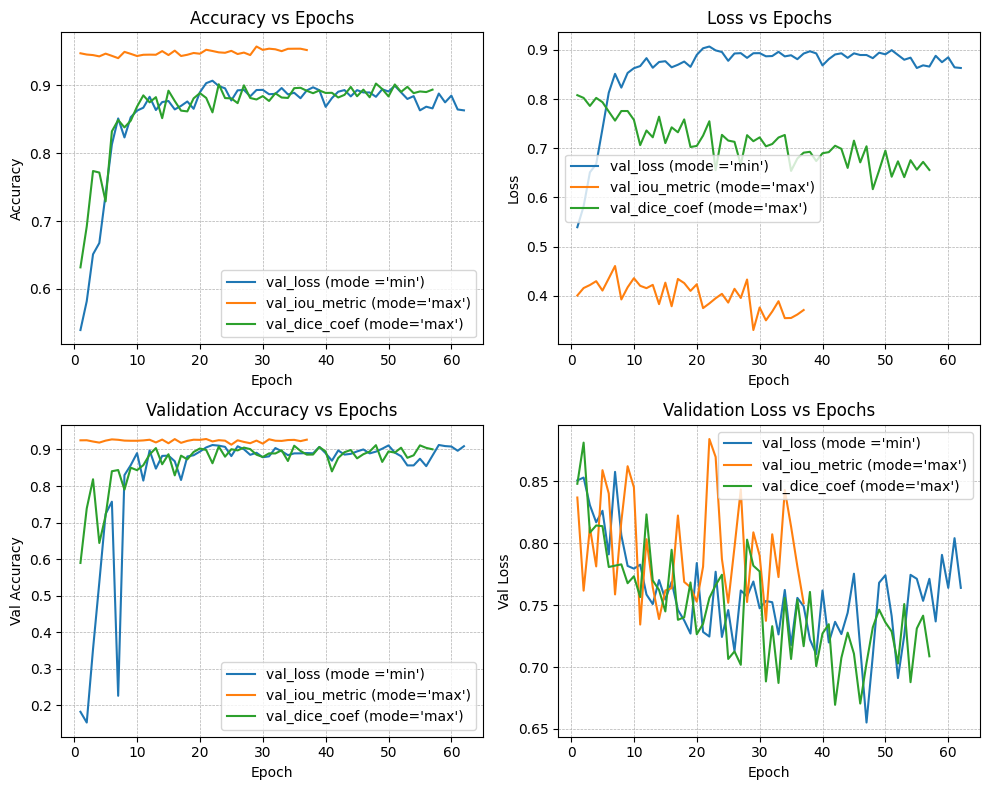

In [26]:
labels = ["val_loss (mode ='min')", "val_iou_metric (mode='max')", "val_dice_coef (mode='max')"]
plot_training_curves(
    acc_list=[acc_1, acc_2, acc_3],
    loss_list=[loss_1, loss_2, loss_3],
    val_acc_list=[val_acc_1, val_acc_2, val_acc_3],
    val_loss_list=[val_loss_1, val_loss_2, val_loss_3],
    labels=labels
)